## Instruction
In this notebook, We use data which I donwload from Tushare to make up some alpha factors and risk factors.
1. Load data which time range bettwen 2018.1 - 2023.3. download from privious step `DownLoad_from_Tushare.ipynb` 
2. Make up some factors based on some paper, tech indicators and fundamentls

## Load Data
load data which already download from Tushare

In [1]:
import pandas as pd 
import numpy as np
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [7, 4]

from alpha_191 import Alpha191

import warnings
warnings.filterwarnings('ignore')

In [ ]:
universe_raw = pd.read_csv('tushare_data/raw_20180101_20230407.csv').iloc[:,1:]
fundamental_df = pd.read_csv('tushare_data/fundamental_20180101_20230407.csv').iloc[:,1:]
benchmark_df = pd.read_csv('tushare_data/benchmark_20180101_20230407.csv').iloc[:,1:]
#universe_raw = pd.read_csv('tmp.csv').iloc[:,1:]

In [ ]:
universe = universe_raw.rename(columns={'vol':'volume'})
universe = universe.drop_duplicates(subset=['ts_code','trade_date'])
universe.head()

In [ ]:
print(len(universe.ts_code.unique()), universe.shape)
print(len(fundamental_df.ts_code.unique()))
print(len(universe.columns), universe.columns)

## Data Explain
  Some data columns about fundamental indicators below:
  
  - 'ts_code','ann_date',
  - 'cfps','revenue_ps','gross_margin', # 每股现金流，每股营业收入, 毛利
  - 'dt_eps','dt_eps_yoy',              # 每股收益， 每股收同比益增长率
  - 'bps','bps_yoy',                    #每股净资产，每股净资产同比增长率
  - 'extra_item','profit_dedt',         # 扣非，扣非净利润
  - 'roe_dt','roe_yoy',                 #净资产收益，净资产收益同比增长率
  - 'ebt_yoy','or_yoy'                  # 总利润增长率，营业收入增长率
  
  If there are some columns named alpha begin, the data had processed completed. Each column named alpha_ is alpha factors

### Filter Custom Tickers Pool

In [ ]:
universe = universe.loc[universe.ts_code.isin(fundamental_df.ts_code.unique())]
#universe.loc[(universe['revenue_ps']==0) & (universe['trade_date']==20190103)].ts_code.unique()
#universe.loc[universe.ts_code=='002940.SZ'][['ts_code', 'trade_date', 'name','close','pe','revenue_ps','list_date']]

In [ ]:
# remove tickers by each day not exist history
def remove_tickers(df, exist_ticker_list):
    diff_df = df.loc[df.ts_code.isin(exist_ticker_list)==False]
    if diff_df.empty == False:
        # remove tickers not exist over 3month from day
        diff1 = (pd.to_datetime(diff_df['trade_date'],format='%Y%m%d')\
                -pd.to_datetime(diff_df['list_date'],format='%Y%m%d')).dt.days < 22
        
        # remove 
        # remove liquid few than 5 millon
        diff2 = diff_df['amount']<3000
        
        diff3 = diff_df['total_share'] > 60000
        #diff4 = diff_df['close'] > 30
        diff5 = diff_df['dt_eps'] <= 0.4
        diff6 = diff_df['pe'] > 35
        diff7 = diff_df['pb'] > 4
        diff8 = diff_df['total_mv'] > 1200000
        #diff8 = diff_df['revenue_ps']>0
        
        # get remove df
        diff_df = diff_df.loc[diff1| diff2| diff3| diff5| diff6| diff7| diff8]
        # get rest data
        df = df.loc[df.ts_code.isin(diff_df.ts_code)==False]
    return df

calendar = universe.trade_date.unique()
df_all = pd.DataFrame()
for dt in tqdm(calendar, desc='filter tikers'):
    tmp = universe.loc[universe['trade_date']==dt]
    if df_all.empty:
        tmp = remove_tickers(tmp, [])
    else:
        tmp = remove_tickers(tmp, df_all.ts_code.unique())
    df_all = df_all.append(tmp, ignore_index=True)
universe = df_all
universe['date'] = pd.to_datetime(universe['trade_date'], format='%Y%m%d')
universe = universe.set_index(['date']).sort_values(by=['date'])
# update stock list
#fundamental_df = fundamental_df.loc[fundamental_df.ts_code.isin(universe.ts_code.unique())]
print(universe.shape, len(universe.ts_code.unique()))

## Add Technology Indicators

In [ ]:
import stockstats

class IndicatorHelper(pd.DataFrame):
    """
        add indicators to dataframe
    """

    def __init__(self, data):
        super(IndicatorHelper, self).__init__(data)

        self.stocks = stockstats.StockDataFrame.retype(data.copy())
        self.df = self

    def add_technical_indicator(self, tech_indicator_list):
        """
        calculate technical indicators
        use stockstats package to add technical inidactors
        :param ticker: (df) pandas dataframe
        :param tech_indeicator_list list
        :return: (df) pandas dataframe
        """
        unique_ticker = self.df.ts_code.unique()

        indicator_df = pd.DataFrame()
        for i in tqdm(range(len(unique_ticker)), desc='add tech indicators'):
            temp_indicator = self.stocks[self.stocks.ts_code == unique_ticker[i]]
            temp_indicator = temp_indicator[tech_indicator_list + ['ts_code','trade_date']]
            indicator_df = indicator_df.append(temp_indicator, ignore_index=True)
        
        self.df = self.df.merge(indicator_df, on=["ts_code", "trade_date"], how="left")
        self.df['date'] = pd.to_datetime(self.df['trade_date'],format='%Y%m%d')
        self.df = self.df.set_index(['date']).sort_values(by=['date']).drop_duplicates(['trade_date','ts_code'])
        return self.df
    

In [ ]:
# add tech indicators
tech_indicator_list = ['log-ret','atr_6', 'ppo', 'supertrend'] 
universe = IndicatorHelper(universe).add_technical_indicator(tech_indicator_list)
# 'close_2_kama_20_mstd'

In [ ]:
universe['vwap'] = universe['amount']/universe['volume']*10
universe['alpha_ppo'] = -universe['ppo']
universe['alpha_atr'] = -universe['atr_6']

### Pick time to evalute and store temp to csv

In [ ]:
universe = universe.loc[universe['trade_date']>20200501]
benchmark_df = benchmark_df.loc[benchmark_df['trade_date']>20200501]
universe.to_csv('factor_data/all_150.csv')

### Construct Factors Based on Alpha 191

In [2]:
universe = pd.read_csv('factor_data/all_150.csv').iloc[:,1:]

In [3]:
#universe_bak = universe.copy(deep=True)
alpha = Alpha191(universe, None)

100%|████████████████████████████████████████| 712/712 [00:02<00:00, 337.76it/s]


In [76]:
universe = alpha.alpha030(alpha.df)

alpha030 processing...: 100%|█████████████████| 147/147 [13:29<00:00,  5.50s/it]


In [70]:
universe = alpha.alpha007(alpha.df)

In [6]:
universe = alpha.alpha010(alpha.df)

In [102]:
universe = alpha.alpha016(alpha.df)

alpha016 processing...: 100%|█████████████████| 147/147 [01:06<00:00,  2.22it/s]


In [131]:
universe = alpha.alpha021(alpha.df)

alpha021 processing...: 100%|█████████████████| 147/147 [00:19<00:00,  7.62it/s]


In [169]:
universe = alpha.alpha032(alpha.df)

processing...: 100%|██████████████████████████| 147/147 [01:11<00:00,  2.06it/s]


In [245]:
universe = alpha.alpha_099(alpha.df)

processing...: 100%|██████████████████████████| 147/147 [01:06<00:00,  2.21it/s]


In [311]:
universe = alpha.alpha101(alpha.df)

processing...: 100%|██████████████████████████| 147/147 [01:59<00:00,  1.23it/s]


In [339]:
universe = alpha.alpha111(alpha.df)

In [345]:
universe = alpha.alpha122(alpha.df)

In [360]:
universe = alpha.alpha149(alpha.df)

In [367]:
universe = alpha.alpha176(alpha.df)

processing...: 100%|██████████████████████████| 147/147 [01:09<00:00,  2.10it/s]


In [374]:
universe = alpha.alpha190(alpha.df)

In [299]:
#universe['alpha_volume'] = -np.log(universe['volume'])
#universe['alpha_pb'] = -universe['pb']
#universe['alpha_030'] = -universe['alpha_030']
universe = universe.sort_values(by=['date'])
alpha.df = universe

## Rank Alpha Factors
As computer use factor to compare each oter before all factors had same scales. So we rescale each factors by Rank in each day and each industry. 

Here we pick some features as mechine learning step in the next step.

In [400]:
from scipy.stats import zscore

factor_names = [
            'alpha_atr', 'alpha_pb',
            'alpha_010', 'alpha_030', 'alpha_016', 'alpha_021','alpha_040','alpha_122','alpha_149',
            'alpha_190', 'alpha_skew2sentiment',#'alpha_winlos'
            ]

def zscore_by_sector(df, zscore_features):
    df_all = pd.DataFrame()
    for industry in df.industry.unique():
        tmp = df.loc[df.industry == industry]
        tmp[zscore_features] = tmp.groupby('trade_date')[zscore_features].rank(pct=True).apply(zscore)
        df_all = df_all.append(tmp)

    return df_all.sort_values(by=['date'])

universe = universe.fillna(0.)
universe = universe[~universe.isin([np.inf, -np.inf]).any(1)]
universe = zscore_by_sector(universe, factor_names)

### Evaluate Alpha Factors

In [412]:
all_factors = universe.copy(deep=True)[factor_names + ['trade_date','ts_code','industry']]
all_factors.reset_index(drop=True, inplace=True)
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date','ts_code']).sort_values(by=['date'])
print(all_factors.shape)

(72224, 12)


<AxesSubplot:>

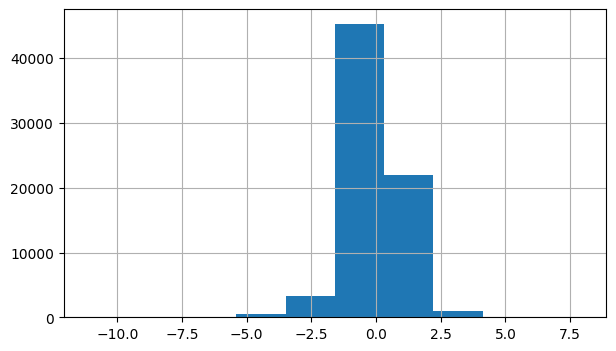

In [413]:
#universe['alpha_122'] = -universe['alpha_122']
all_factors['alpha_skew2sentiment'].hist()

In [414]:
import alphalens as al
from scipy.stats import zscore
import helper.project_helper as ph

shift_day = -5
tmp = universe.copy(deep=True)
tmp['close'] = tmp.groupby('ts_code')['close'].shift(shift_day)
all_pricing = tmp.reset_index().pivot(index='date', columns='ts_code', values='close')
#all_pricing = all_pricing.loc[all_pricing.index[::5]]

def show_sample_results(factors_with_alpha, features, pricing=all_pricing, holding_time=1):
    factors_with_alpha = factors_with_alpha[features]
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha, pricing, holding_time=holding_time)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = ph.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)

#all_pricing.head()

Cleaning Data...

Dropped 2.4% entries from factor data: 2.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.4% entries from factor data: 2.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.4% entries from factor data: 2.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.4% entries from factor data: 2.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.4% entries from factor data: 2.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

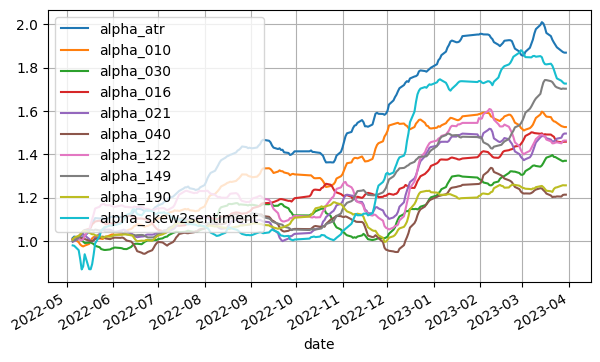

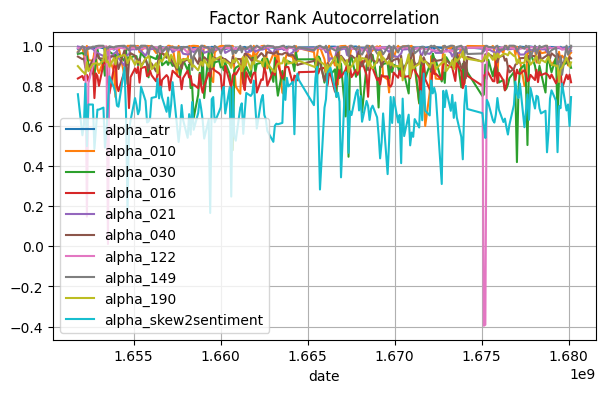

In [415]:
eva_df = all_factors.loc[all_factors['trade_date']>20220501]
show_sample_results(eva_df, factor_names, pricing=all_pricing, holding_time=5)

### View factor to single ticker

In [329]:
cond1 = universe['trade_date']>20220501
universe.loc[cond1][['ts_code','name','industry','alpha_040','alpha_069']].sort_values(by=['alpha_040'])

,ts_code,name,industry,alpha_040,alpha_069
date,,,,,
2023-03-28,688298.SH,东方生物,医疗保健,-1.761686,0.000000
2023-03-24,688298.SH,东方生物,医疗保健,-1.743563,0.000000
2023-03-23,688298.SH,东方生物,医疗保健,-1.743563,0.000000
2023-03-22,688298.SH,东方生物,医疗保健,-1.743563,0.000000
2023-03-21,688298.SH,东方生物,医疗保健,-1.743563,0.000000
...,...,...,...,...,...
2022-08-17,002940.SZ,昂利康,化学制药,1.701677,0.428145
2022-07-13,603520.SH,司太立,化学制药,1.701677,0.438541
2022-12-30,603669.SH,灵康药业,化学制药,1.701677,0.543796


<AxesSubplot:title={'center':'alpha_069'}, xlabel='date'>

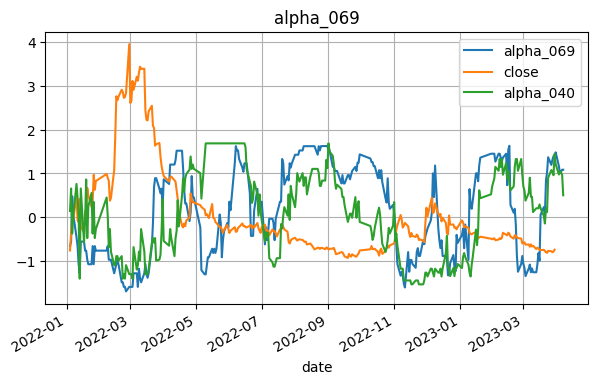

In [72]:
name1 = 'alpha_069'
name2 = 'alpha_040'
# & (universe['trade_date']>20190901) 
rescale_universe = universe.copy()

#rescale_universe[[name]] = rescale_universe.groupby('trade_date')[[name]].rank(method='min', pct=True)#.apply(zscore)

# 'alpha_149'
cond1 = rescale_universe.ts_code=='300584.SZ'
cond2 = rescale_universe['trade_date']>20220101
tmp = rescale_universe.loc[cond1 & cond2][[name1,'close', name2]]
#tmp[['close',name]] = tmp[['close', name]].apply(zscore)
tmp[['close']] = tmp[['close']].apply(zscore)
tmp['close'] = tmp['close'].shift(-5)
tmp.plot(title=name1, grid=True)

## Construct Factors Based on Paper

### Winner And Loser
This factor we also did in P4. It express a ticker how to reach a return in a spicific period time 

We use a time window as T, and regression d and v $return = T*d + T^2*v$  => $factor=d*v$ 

In [10]:
from statsmodels.formula.api import ols

class WinnerAndLoser(pd.DataFrame):
    """
        Winner and Loser Factor Constructor
    """
    def __init__(self,data, win_length=14):
        super(WinnerAndLoser, self).__init__(data)
        self.df = self
        self.win_lenth = win_length

    def _regression(self, data):
        df = pd.DataFrame(data, columns=['log-ret'])
        df['acc_ret'] = df['log-ret'].cumsum()
        df['t_dir'] = np.arange(self.win_lenth)+1
        df['t_velocity'] = df['t_dir'] ** 2
        regression = ols(formula='acc_ret ~ 0 + t_dir + t_velocity', data=df)
        model = regression.fit()
        data['alpha_winlos'] = model.params.t_dir * model.params.t_velocity
        return  data['alpha_winlos']


    def calculate(self):
        '''
        convert time to value
        regress return to get mu and beta each time
        add facotor mu*beta to colomns
        :return: dataframe
        '''
        tickers = self.df.ts_code.unique()
        factor_df = pd.DataFrame()
        for ticker in tqdm(tickers, desc='winner and loser'):
            tmp_df = self.df.loc[self.df.ts_code == ticker][['trade_date', 'ts_code', 'log-ret']]
            tmp_df['alpha_winlos'] = tmp_df['log-ret'].rolling(self.win_lenth).apply(self._regression)
            tmp_df['alpha_winlos'].fillna(method='bfill',inplace=True)
            factor_df = factor_df.append(tmp_df, ignore_index=True)
        self.df = self.df.merge(factor_df[["ts_code", "trade_date", "alpha_winlos"]], on=["ts_code", "trade_date"], how="left")
        self.df['date'] = pd.to_datetime(self.df['trade_date'],format='%Y%m%d')
        self.df = self.df.set_index(['date']).sort_values(by=['date'])
        return  self.df
    
    
#test = universe.loc[universe.ts_code=='603538.SH']
#test = universe.loc[universe.ts_code=='002038.SZ']
#test = WinnerAndLoser(test).calculate()
universe = WinnerAndLoser(universe).calculate()

winner and loser: 100%|███████████████████████| 147/147 [11:26<00:00,  4.67s/it]


### Skew And Momentum
This factor we also did in P4. It express minority and majority sentiment of investor how to impact on market.

We calculate skew and median of log-return distribution in a period time, the skew view as marjority sentiment and median can view as minority sentiment.

$factor = skew * median 

In [405]:
class SkewandMomentum(pd.DataFrame):
    """
        Expected Skewness and Momentum Factor Constructor
    """
    def __init__(self,data, win_length=10):
        super(SkewandMomentum, self).__init__(data)
        self.df = self
        self.win_length = win_length

    def calculate(self):
        '''
        convert time to value
        regress return to get mu and beta each time
        add facotor mu*beta to colomns
        :return: dataframe
        '''
        def calculate_factor(data):
            return data.skew() * data.median()
        
        tmp_df = pd.DataFrame()
        for stock_tuple in tqdm(self.groupby('ts_code'), desc='skew and momentum'):
            stock = stock_tuple[1]
            stock['alpha_skew2sentiment'] = stock['log-ret'].rolling(self.win_length).apply(calculate_factor)
            stock['alpha_skew2sentiment'] = stock['alpha_skew2sentiment'].fillna(method='bfill')
            tmp_df = tmp_df.append(stock,ignore_index=True)
        self.df = self.df.merge(tmp_df[["ts_code", "trade_date", "alpha_skew2sentiment"]], on=["ts_code", "trade_date"], how="left")
        self.df['date'] = pd.to_datetime(self.df['trade_date'],format='%Y%m%d')
        self.df = self.df.set_index(['date']).sort_values(by=['date'])
        return self.df
universe = universe.drop(columns=['alpha_skew2sentiment'])
universe = SkewandMomentum(universe).calculate()

skew and momentum: 100%|██████████████████████| 147/147 [00:28<00:00,  5.11it/s]


In [ ]:
universe[['alpha_skew2sentiment', 'alpha_winlos']] = universe[['alpha_skew2sentiment', 'alpha_winlos']].fillna(0)
universe[['alpha_skew2sentiment', 'alpha_winlos']] \
    = universe.groupby('trade_date')[['alpha_skew2sentiment', 'alpha_winlos']].apply(zscore)

## Save All Data and factors to csv

In [416]:
universe.columns

Index(['ts_code', 'trade_date', 'turnover_rate', 'pe', 'pb', 'total_share',
       'free_share', 'total_mv', 'circ_mv', 'name', 'industry', 'list_date',
       'volume', 'amount', 'open', 'close', 'high', 'low', 'rsi_6', 'rsi_12',
       'ann_date', 'type', 'p_change_min', 'p_change_max', 'issue_price',
       'issue_amount', 'cfps', 'revenue_ps', 'gross_margin', 'dt_eps',
       'dt_eps_yoy', 'bps', 'bps_yoy', 'extra_item', 'profit_dedt', 'roe_dt',
       'roe_yoy', 'ebt_yoy', 'or_yoy', 'log-ret', 'atr_6', 'ppo', 'supertrend',
       'vwap', 'alpha_ppo', 'alpha_atr', 'rsize', 'rvalue', 'alpha_040',
       'alpha_069', 'alpha_010', 'alpha_volume', 'alpha_winlos', 'alpha_pb',
       'alpha_007', 'alpha_030', 'alpha_012', 'alpha_016', 'alpha_017',
       'alpha_019', 'alpha_021', 'alpha_023', 'alpha_025', 'alpha_032',
       'alpha_035', 'alpha_056', 'alpha_075', 'high_r', 'volume_r',
       'alpha_083', 'alpha_089', 'alpha_098', 'alpha_099', 'alpha_101',
       'alpha_103', 'alpha_116',

In [418]:
tmp_features = ['ts_code', 'trade_date', 'name', 'industry', 'close', 'issue_price','log-ret',
                'alpha_atr', 'alpha_pb', 'alpha_ppo', 'alpha_winlos', 'alpha_skew2sentiment',
                'alpha_010', 'alpha_030', 'alpha_016', 'alpha_021','alpha_040','alpha_122','alpha_149', 'alpha_190'
               ]

universe_tmp = universe[tmp_features]
universe_tmp.to_csv('factor_data/all_147_zscore.csv')